In [76]:
import pandas as pd
import numpy as np
import mnist

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

## Load the dataset

The MNIST database is available at http://yann.lecun.com/exdb/mnist/

The MNIST database is a dataset of handwritten digits. It has 60,000 training samples, and 10,000 test samples. Each image is represented by 28x28 pixels, each containing a value 0 - 255 with its grayscale value.

We will be using the `mnist` library to download images and labels from the MNIST database

The dataset is downloaded and cached in your temporary directory, so, calling the functions again, is much faster and doesn't hit the server.

In [65]:
import mnist

train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [66]:
print(f'train images shape: {train_images.shape}')
print(f'test images shape: {test_images.shape}')

train images shape: (60000, 28, 28)
test images shape: (10000, 28, 28)


## MNIST Images and labels

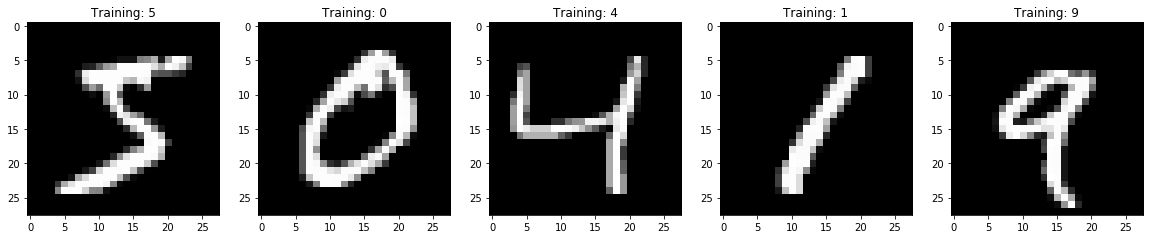

In [67]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_images[:5], train_labels[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Training: {label}')

## Preprocessing

For each algorithm, we will use a couple of data preprocessing techniques listed below to see how the it performs, if there is an improvement in the error rate:

1.  Deskewing
2.  Noise removal
3.  Blurring
4.  N-pixel shift
5.  Shiftable edges
6.  Subsampling
7.  Shape context feature extraction
8.  Haar features
9.  Width normalization
10. Deslanting
11. None of the above

## Training and prediction using Logistic Regression

In [68]:
# Flatten images since the algorithm expects a 2d array

def flatten_images(images):
    n_samples, x_pixels, y_pixels = images.shape
    return images.reshape(n_samples, x_pixels * y_pixels)
    
train_data = flatten_images(train_images)
test_data = flatten_images(test_images) 

In [69]:
# lbfgs is chosen as the optimization algorithm as it is suitable for multiclass problems

clf = LogisticRegression(solver='lbfgs').fit(train_data, train_labels)

In [70]:
predictions = clf.predict(test_data)

In [71]:
score = accuracy_score(test_labels, predictions)
score

0.9255

## Confusion Matrix

Exploring the confusion matrix, just for fun

In [72]:
confusion_matrix = confusion_matrix(test_labels, predictions)
print(confusion_matrix)

[[ 963    0    0    3    1    3    4    4    2    0]
 [   0 1112    4    2    0    1    3    2   11    0]
 [   3   10  926   15    6    4   15    8   42    3]
 [   4    1   21  916    1   26    3    9   22    7]
 [   1    1    7    3  910    0    9    7   10   34]
 [  11    2    1   33   11  776   11    6   35    6]
 [   9    3    7    3    7   16  910    2    1    0]
 [   1    6   24    5    7    1    0  951    3   30]
 [   8    7    6   23    6   26   10   10  869    9]
 [   9    7    0   11   25    6    0   22    7  922]]


In [73]:
confusion_matrix[:, 9]

array([  0,   0,   3,   7,  34,   6,   0,  30,   9, 922], dtype=int64)

In [74]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

accuracy(confusion_matrix)

0.9255

From the confusion matrix, we can observe the following for the misclassified images:
- Majority of the images for 0 are wrongly predicted as 5,6,8,9
- Majority of the images for 1 are wrongly predicted as 2,7,8,9
- Majority of the images for 2 are wrongly predicted as 3,7
- Majority of the images for 3 are wrongly predicted as 2,5,8,9
- Majority of the images for 4 are wrongly predicted as 5,9
- Majority of the images for 5 are wrongly predicted as 3,6,8
- Majority of the images for 6 are wrongly predicted as 2,5,8
- Majority of the images for 7 are wrongly predicted as 8,9
- Majority of the images for 8 are wrongly predicted as 1,2,3,4,5
- Majority of the images for 9 are wrongly predicted as 4,7

They don't seem to follow any specific pattern apart from the fact that numbers that resemble same patterns are misclassified.

## Testing output for sanity check

Let us do a sanity check to see how the images look for both correctly classified and misclassified predictions and see if we can uncover more from the samples.

In [156]:
# Getting indexs for both misclassified and correctly classified images

index = 0
misclassified_images = []
correctly_classified_images = []

for label, predict in zip(test_labels, predictions):
    if label == predict:
        correctly_classified_images.append(index)
    else:
        misclassified_images.append(index)
    index += 1

### Display correctly classified images

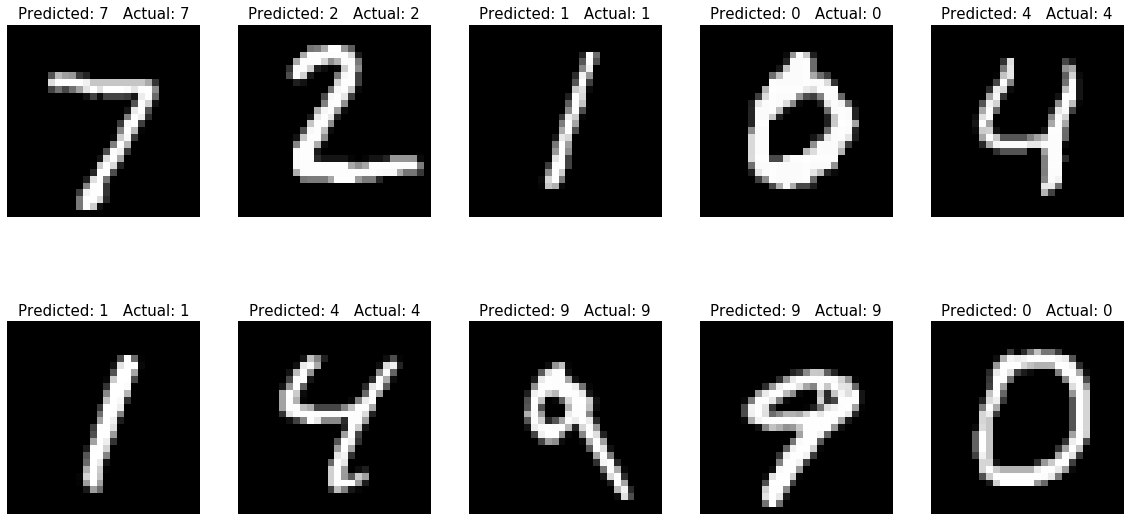

In [160]:
plt.figure(figsize=(20, 10))

for i, correctly_classified_index in enumerate(zip(correctly_classified_images[: 10])):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.reshape(test_data[correctly_classified_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[correctly_classified_index]}   Actual: {test_labels[correctly_classified_index]}', 
              fontsize = 15)
    plt.axis('off')


From the above list, we can make out that the images that were correctly classified have a clear distinction,not too blurry. The model also identified few numbers that were slanting. For example: the number 9 in the last row.

### Display misclassified images

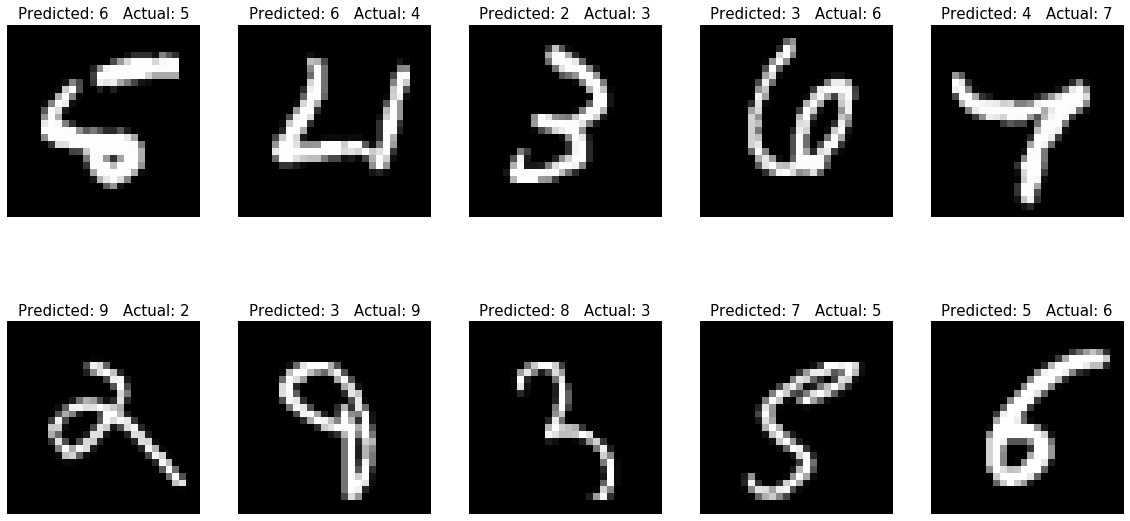

In [165]:
plt.figure(figsize=(20, 10))

i = 0
for misclassified_images_index in (misclassified_images[0:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.reshape(test_data[misclassified_images_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[misclassified_images_index]}   Actual: {test_labels[misclassified_images_index]}', 
              fontsize = 15)
    plt.axis('off')
    i += 1

From the above, we can notice that most of the incorrectly classified digits are hand written, some numbers do not have clear shapes and are blurry. Let us see how the model is misclassifying for each digit.

#### Misclassified images for the digit 1

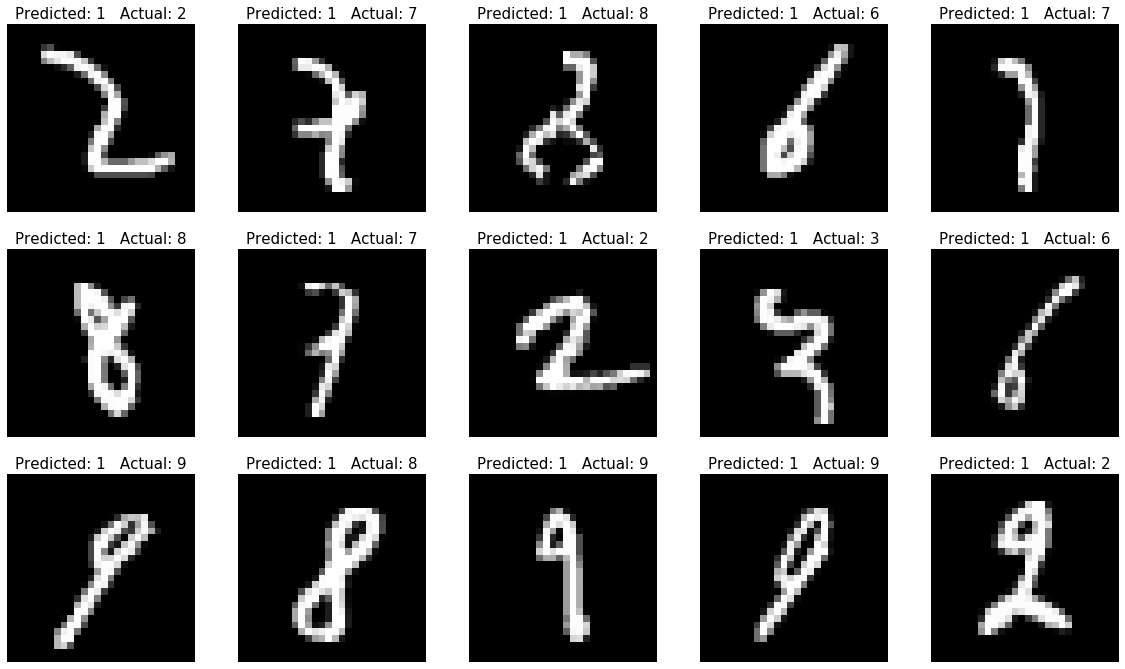

In [167]:
# A method that displays a list of misclassified images for a given number

def show_image(i, image_index):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(test_data[image_index], (28, 28)), cmap=plt.cm.gray)
    plt.title(f'Predicted: {predictions[image_index]}   Actual: {test_labels[image_index]}', 
              fontsize = 15)
    plt.axis('off')

# Displays images for a given number. 
# For ex: if 6 is passed as num, the method displays all images that were predicted as 6 
def display_images_for_number(predicted_list, num):
    plt.figure(figsize=(20, 20))

    i = 0
    for predicted_index in (predicted_list):
        if predictions[predicted_index] == num:
            show_image(i, predicted_index)
            i += 1
            
           
display_images_for_number(misclassified_images[0:250], 1)

Most of the images misclassified as 1 seem to have a  clear straight line

#### Misclassified images for the digit 2

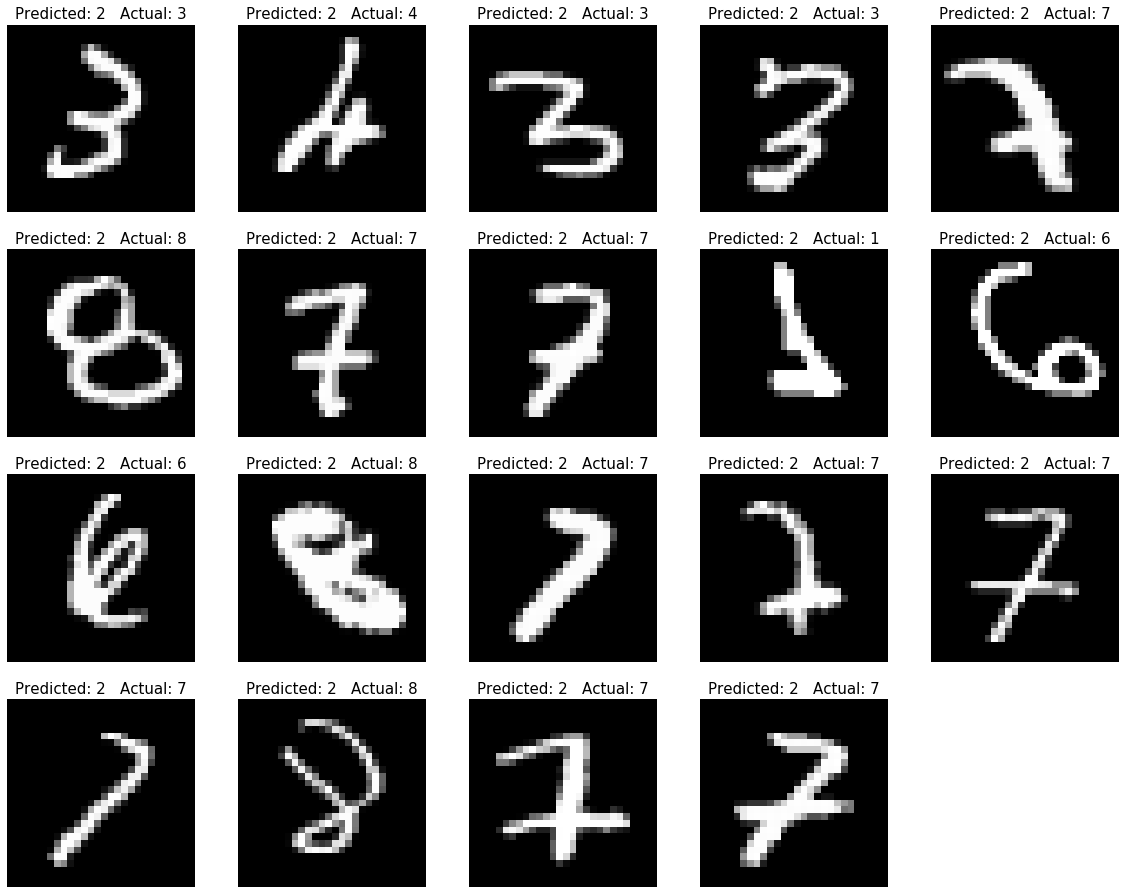

In [169]:
display_images_for_number(misclassified_images[0:200], 2)

A lot of 7's seem to be misclassified as 2

#### Misclassified images for the digit 3

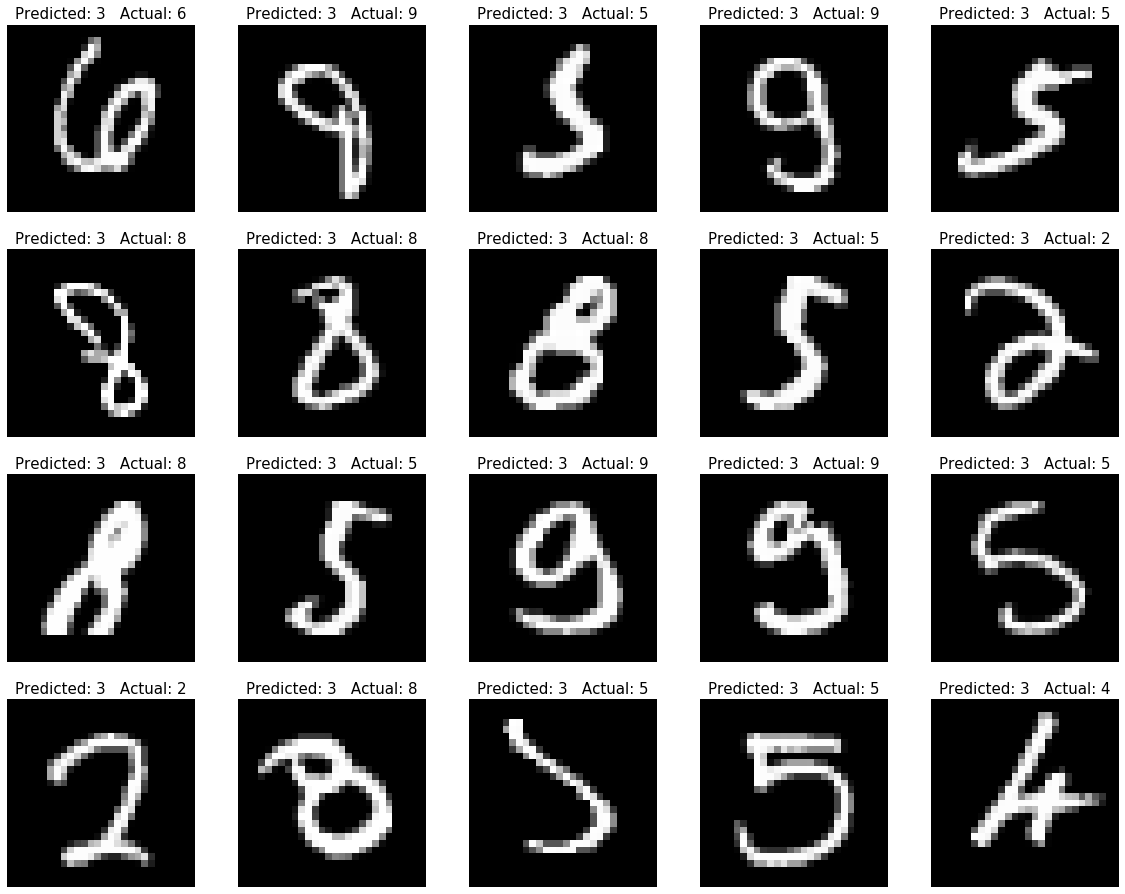

In [172]:
display_images_for_number(misclassified_images[0:150], 3)

Majority of the numbers misclassified as 3 include 8, 5 and 9

#### Misclassified images for the digit 4

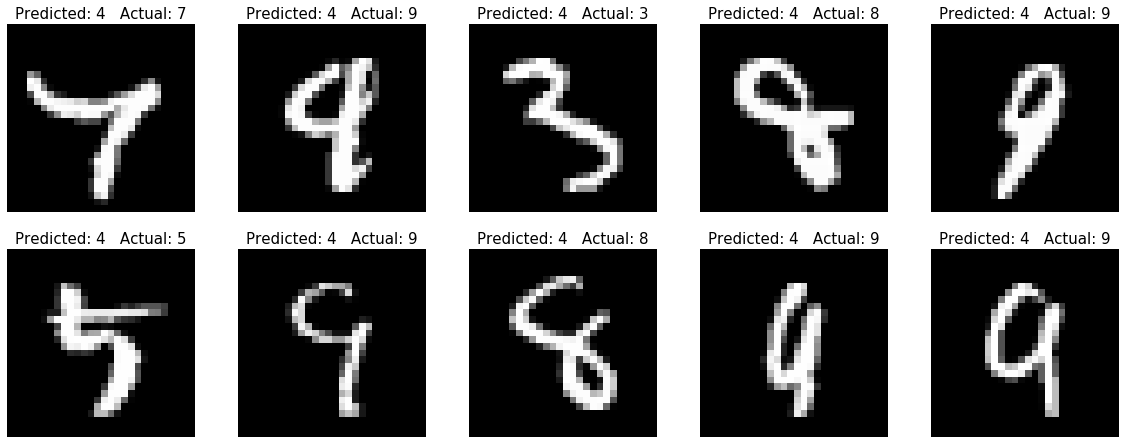

In [173]:
display_images_for_number(misclassified_images[0:150], 4)

It's weird that the model is misclassifying 3 as 4, although in this image, the pattern of the image 3 is nowhere close to 4. Could it be because the number is slanting?

#### Misclassified images for the digit 5

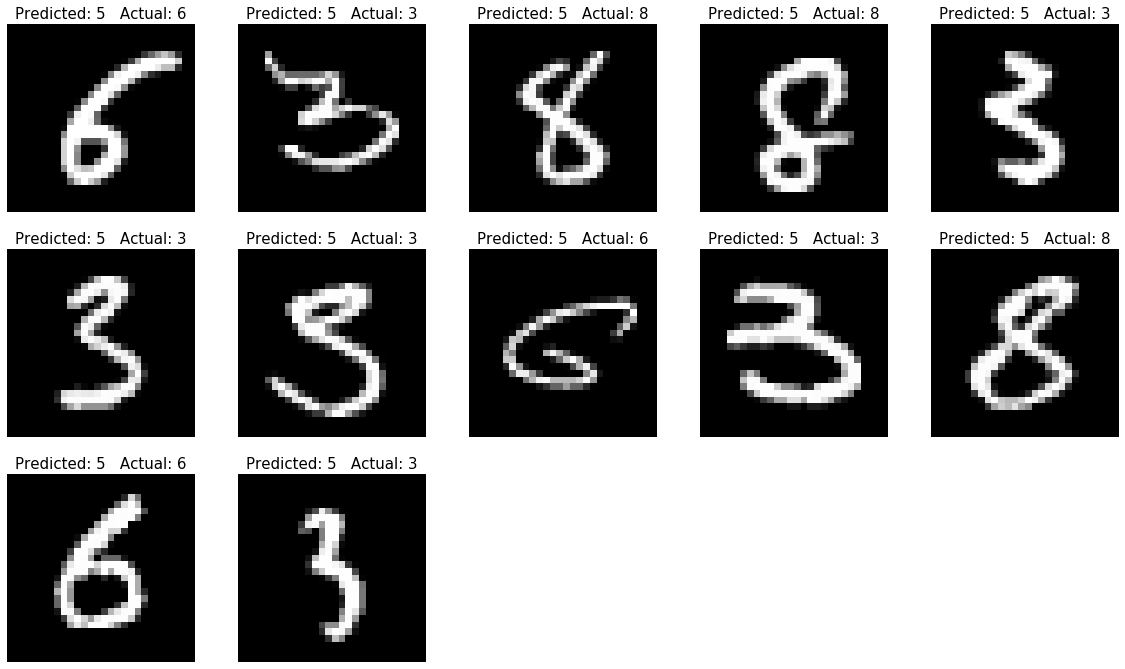

In [174]:
display_images_for_number(misclassified_images[0:150], 5)

The numbers seem to resemble the pattern 5 and also some are not very clear.

#### Misclassified images for the digit 6

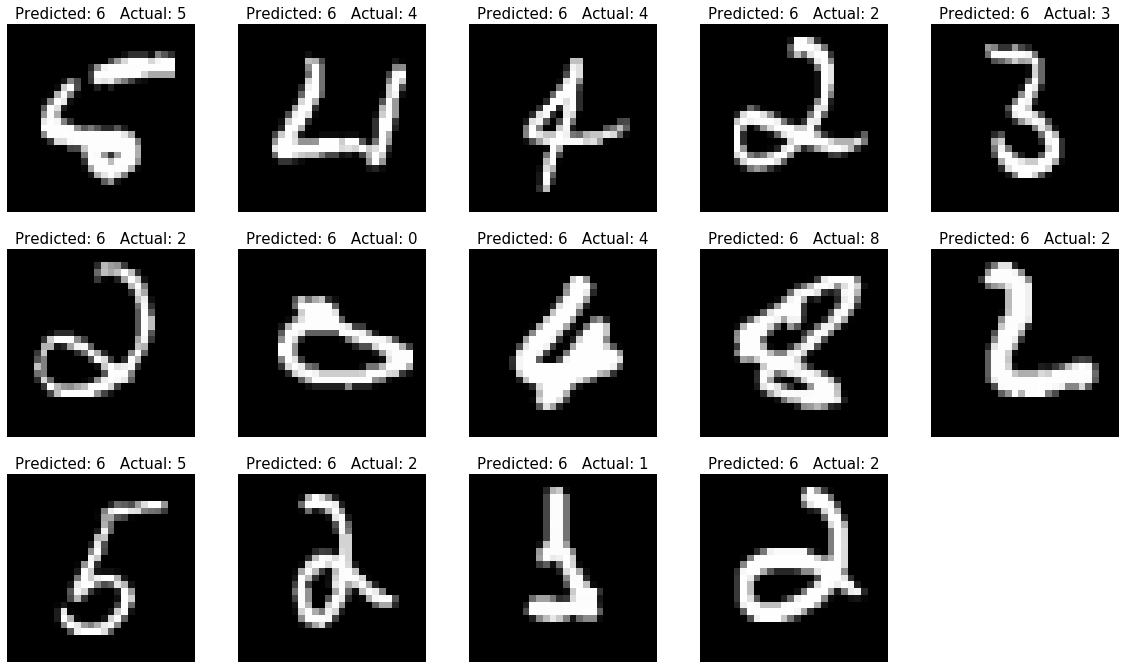

In [175]:
display_images_for_number(misclassified_images[0:150], 6)

#### Misclassified images for the digit 7

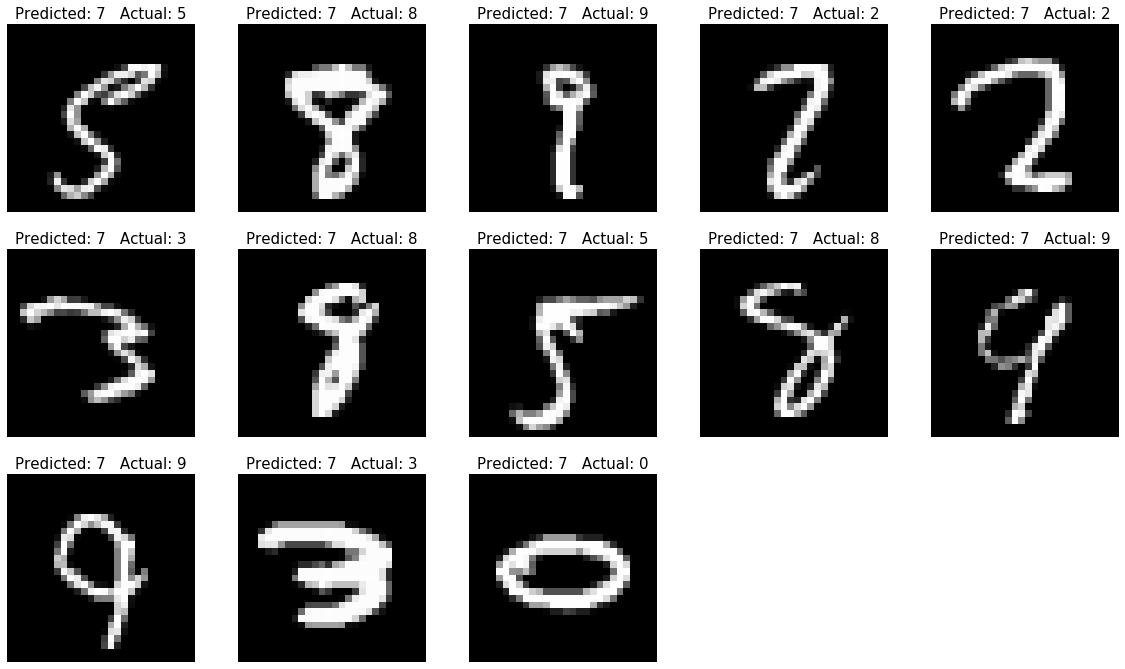

In [177]:
display_images_for_number(misclassified_images[0:100], 7)

It is interesting to see that 0, which has a clear distinction is being misclassified as 7. It could be because it looks like it is tilted by 90 degrees. May be we should train the model with images tilted in different directions.

#### Misclassified images for the digit 8

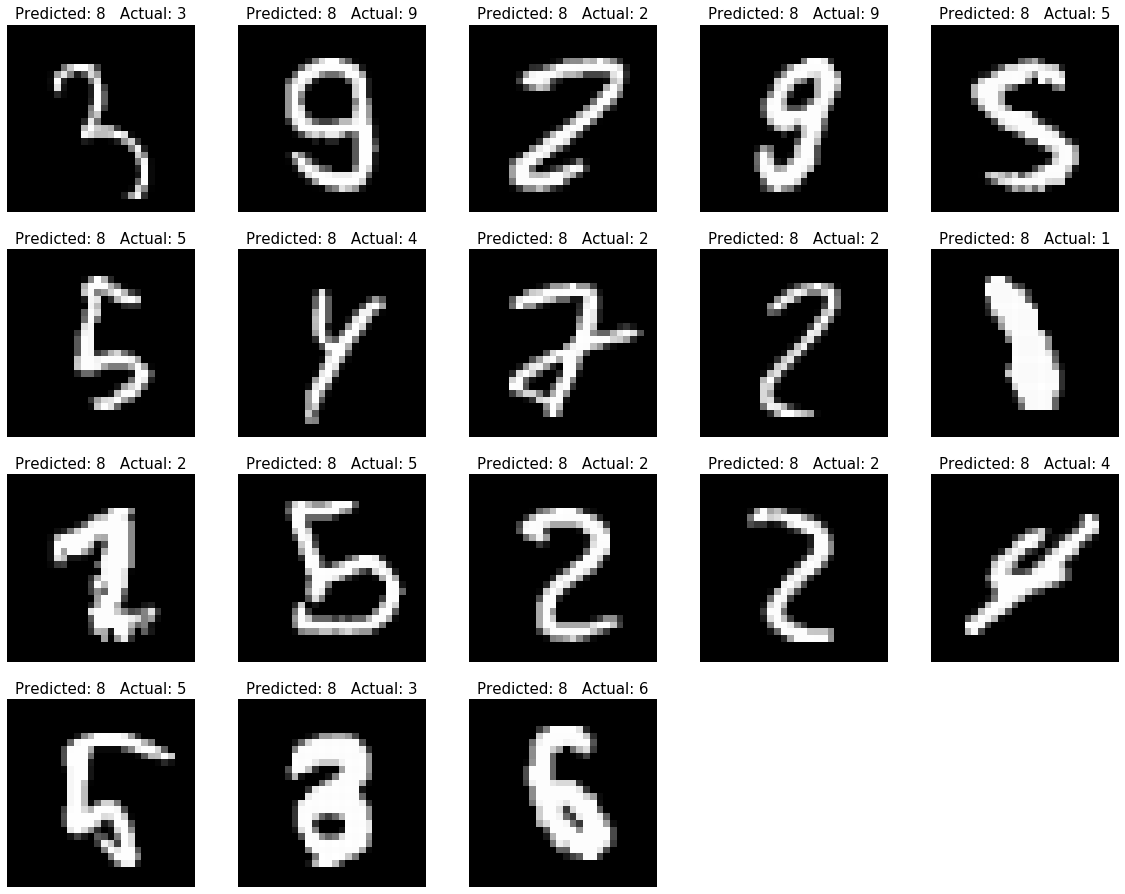

In [178]:
display_images_for_number(misclassified_images[0:100], 8)

It looks like all unclear handwritten digits are getting misclassified as 8

#### Misclassified images for the digit 9

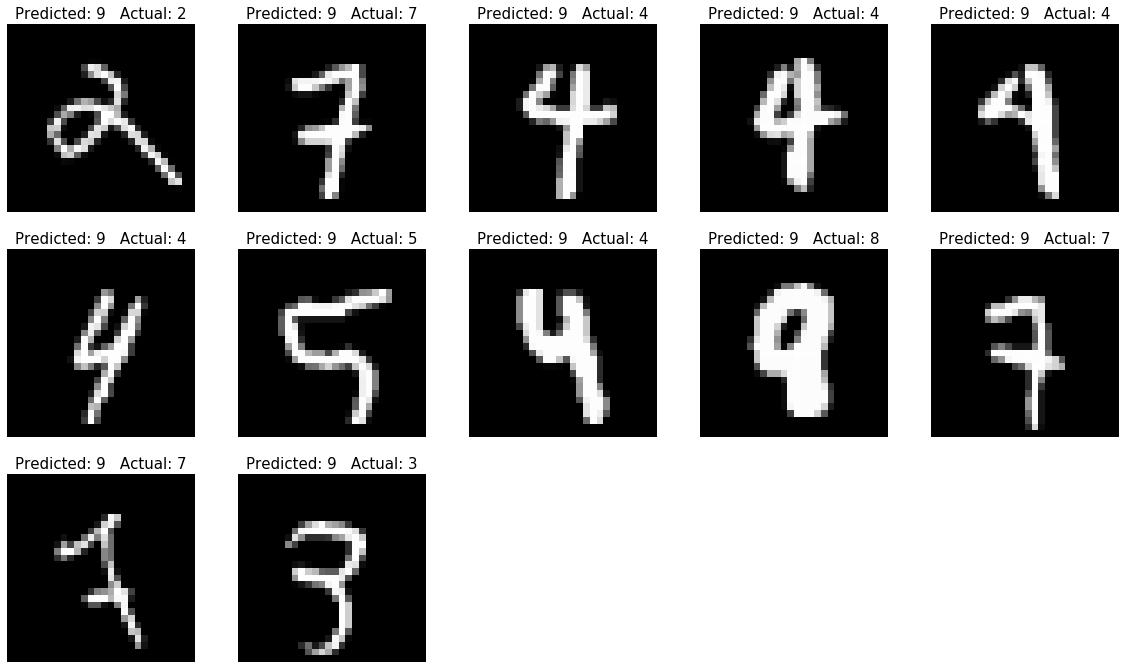

In [179]:
display_images_for_number(misclassified_images[0:100], 9)

Most of the 4's are getting misclassified as 9.

#### Misclassified images for the digit 0

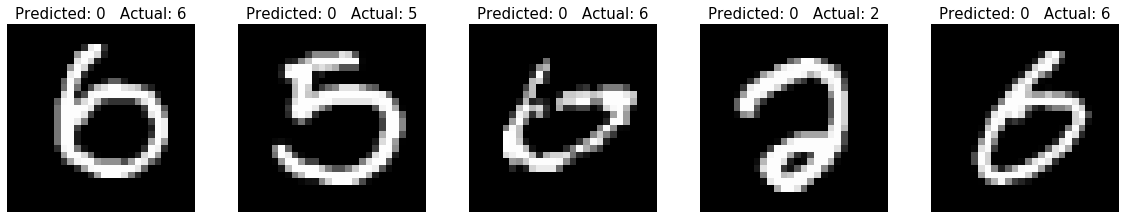

In [181]:
display_images_for_number(misclassified_images[0:100], 0)

Any number that resembles a zero is getting misclassified.

To summarize, we could do the following to help improve the model:

1. 8 seems to be the most wrongly classified image. Improve training data for 8
2. Blurry handwritten (by probably students) seem to be the most misclassified. Train the model with more such images.
3. 



## Testing the algorithm with synthetic data (WIP)

In [120]:
from sklearn.datasets import make_gaussian_quantiles
# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=3.,
                                 n_samples=1000, 
                                 n_classes=10, random_state=1)
X1 = pd.DataFrame(X1,columns=['x','y'])
y1 = pd.Series(y1)

clf = LogisticRegression(solver='lbfgs').fit(X1.x.values.reshape((-1,1)), X1.y)

ValueError: Unknown label type: 'continuous'

In [103]:
X1.head()

,x,y
0,0.590950,2.406783
1,1.332815,2.137236
2,-1.039639,-2.156644
3,-0.977517,-1.270446
4,2.110992,1.818490


In [105]:
train_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [84]:
clf = LogisticRegression(solver='lbfgs').fit(X1, y1)
predictions = clf.predict(test_data)

ValueError: X has 784 features per sample; expecting 2

References:
Confusion matrix: https://www.python-course.eu/confusion_matrix.php
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
Synthetic data generation:
https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae
https://towardsdatascience.com/do-you-need-synthetic-data-for-your-ai-project-e7ecc2072d6b
https://towardsdatascience.com/how-uber-uses-synthetic-data-to-speed-up-training-cc989c23ded4
